# Simulating orbits with REBOUND

https://rebound.readthedocs.io/en/latest/api/


In [1]:
pip install rebound

  Using cached rebound-3.22.0-cp39-cp39-linux_x86_64.whl
Note: you may need to restart the kernel to use updated packages.


In [2]:
%matplotlib widget
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import rebound
#from IPython.display import display, clear_output

To run an N-body simulation, we need to create a simulation object first. We will also choose units that are convenient for astronomy.

In [16]:
sim = rebound.Simulation()
sim.units = ('AU','yr','Msun')
sim.G = 39.476926408897626

Then, we add bodies to the simulation. We will star with the star (1.5 solar masses) add then planets in the system from the inside out. Six parameters are required to uniquely specify the orbit of each planet of mass m, and we will use the following observationally determined ones:
 - semi-major axis (a) in au
 - eccentricity (e)
 - inclination (i) in radians
 - PA of the ascending node (Ω) in radians
 - argument of periastron (ω) in radians
 - mean anomaly at a reference epoch (MA_ref) in radians
 

In [17]:
# Central star HR 8799 A
#sim.add(m=1e-6)                
sim.add(m=1.50)                

# co-planar orbits
dtor = np.pi / 180
inc_pl = 27.8 * dtor
Omega_pl = 60.1 * dtor

# planet masses
mass_e = 5e-3
mass_d = mass_e

# add inner most planet: HR 8799 e
sim.add(m=mass_e, a=16.64, e=0.1397, omega=118.8*dtor, M=1.261, inc=inc_pl, Omega=Omega_pl)
# add next planet: HR 8799 d
sim.add(m=mass_d, a=26.29, e=0.1112, omega=24.3*dtor, M=2.032, inc=inc_pl, Omega=Omega_pl)

Now let's set the time steps for numerical integration. A general rule of thumb is that time steps should be at most 10% of the shortest orbital period. The following will compute all orbital elements for our simlated particles and print out their periods. We then select an appropriate time step.

In [18]:
# compute and print orbital period of each planet
for o in sim.calculate_orbits(): 
    print(o.P)

# set the time step
sim.dt = 1.0

55.331180403278644
109.69974242315676


We want to work in the center-of-mass frame throughout this simulation. Now that we have set up some planets we can do that. Let's look at the positions of the host star and two planets before integrating our simulation forward. Are their distances from the origin about where we expect them?

In [19]:
# move to center of mass frame
sim.move_to_com()

# examine initial locations of particles
for p in sim.particles:
    print(p.x, p.y, p.z)

0.0793879433184577 0.10318303044494694 -0.009166426220624668
-1.4945423665386373 -15.693545873851535 -3.441521470625438
-22.321840628998668 -15.261363259632539 6.191449336812838


For fun, let's plot what the orbits we've specified look like and where our planets are to start out with. We'll also save this first timestep so that we can return to it later.

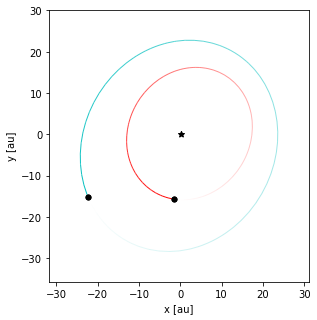

In [20]:
# plot our starting point
op = rebound.OrbitPlot(sim, color=True, periastron=False, unitlabel="[au]")

# save our starting point
sim.save("start.bin")

Now let's actually integrate the orbits forward. The code below will iteratively integrate more and more time, stopping occasionally to display where the planets are at. Feel free to play with the number of frames and the time between displaying frames

Note: once you've run this block once, the simulation will always pick up where you left off. It won't start from the initial conditions. This is good if you want to keep exploring farther and farther in time, but bad if you want to re-run the experiment to check numbers.

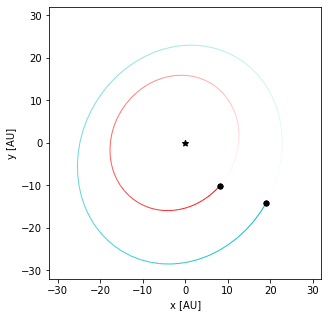

In [21]:
nframe = 541 # at home, I found 100 frames takes about 30 seconds to render
framestep = 5*sim.dt

op = rebound.OrbitPlot(sim,color=True,unitlabel="[AU]",xlim=[-32,32.],ylim=[-32,32.])
fig = op.fig
for i in range(nframe):
    sim.integrate(sim.t + framestep)
    op.update()       # update data
    fig.canvas.draw() # redraw figure

Let's see if the orbital elements of the planets have changed. In a stable system, they should only change negligibly with time.

In [22]:
# check time run so far
sim.status()

# move to center of mass frame
sim.move_to_com()

# compute and print orbital elements of each planet
print()
print("a, e, omega, inc, Omega")
for o in sim.calculate_orbits(): 
    print(o.a, o.e, o.omega/dtor, o.inc/dtor, o.Omega/dtor)

---------------------------------
REBOUND version:     	3.22.0
REBOUND built on:    	Nov 29 2022 00:39:21
Number of particles: 	3
Selected integrator: 	ias15
Simulation time:     	2.7050000000000000e+03
Current timestep:    	0.613502
---------------------------------
<rebound.particle.Particle object at 0x7f7857138f40, m=1.5 x=-0.09067667627903056 y=0.08063290753049229 z=0.0626371001672204 vx=-0.007051777330458021 vy=-0.009577982168971667 vz=0.0007057933260409965>
<rebound.particle.Particle object at 0x7f78571386c0, m=0.005 x=8.101679212573105 y=-10.134251140350624 z=-6.36648818704247 vx=1.3975463073799685 vy=1.5852078244142553 vz=-0.22213772468425197>
<rebound.particle.Particle object at 0x7f7857138f40, m=0.005 x=19.10132367113566 y=-14.055621118794978 z=-12.42464186312289 vx=0.7179868917574382 vy=1.2881868262772458 vz=0.010399726871952945>
---------------------------------

a, e, omega, inc, Omega
16.596349625660554 0.16136940954471807 298.8526232149542 27.8 60.10000000000004
26.5081

There are actually two more (known) planets in the HR 8799 system. So let's go ahead and return to our original time step and add those in.

In [8]:
# reset sim
del sim
sim = rebound.Simulation("start.bin")

# planet masses
mass_c = mass_e
mass_b = 3e-3

sim.add(m=mass_c, a=43.12, e=0.0561, omega=28.5*dtor, M=4.232, inc=inc_pl, Omega=Omega_pl)
sim.add(m=mass_b, a=70.50, e=0.0113, omega=213.6*dtor, M=2.642, inc=inc_pl, Omega=Omega_pl)

# move to center of mass frame
sim.move_to_com()

# verify the reset
sim.status()
print()
print("a, e, omega, inc, Omega")
for o in sim.calculate_orbits(): 
    print(o.a, o.e, o.omega/dtor, o.inc/dtor, o.Omega/dtor)

---------------------------------
REBOUND version:     	3.22.0
REBOUND built on:    	Nov 29 2022 00:39:21
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	0.0000000000000000e+00
Current timestep:    	1.000000
---------------------------------
<rebound.particle.Particle object at 0x7f7857ef0040, m=1.5 x=-0.08601052489003369 y=0.05009831148480151 z=0.05247918880877085 vx=-0.007894407743755666 vy=0.0009906727450220013 vz=0.0038686115064337483>
<rebound.particle.Particle object at 0x7f7857ef07c0, m=0.005 x=-1.6599408347471287 y=-15.74663059281168 z=-3.3798758555960426 vx=1.7096727450262574 vy=-0.25869130922962563 vz=-0.849417787860531>
<rebound.particle.Particle object at 0x7f7857ef0040, m=0.005 x=-22.48723909720716 y=-15.314447978592684 z=6.253094951842233 vx=0.5042477054269283 vy=-1.20751521326713 vz=-0.5478353640954631>
<rebound.particle.Particle object at 0x7f7857ef07c0, m=0.005 x=31.981426325924506 y=-22.58483791182247 z=-20.553330101607727 vx=0.59687170148405

TypeError: cannot unpack non-iterable OrbitPlot object

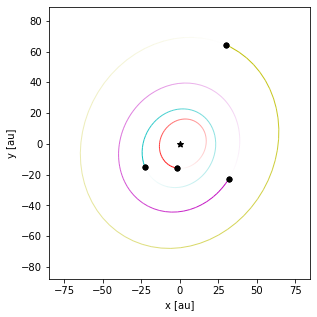

In [9]:
fig, ax = rebound.OrbitPlot(sim, color=True, periastron=False, unitlabel="[au]")

Now let's run a long integration and then see how it looks at the end. (You can try running for as long as you like!)

In [13]:
# run simulation
sim.integrate(100000)

# plot endpoint
#fig, ax = rebound.OrbitPlot(sim, color=True, periastron=False, unitlabel="[au]")

# compute and print orbital elements of each planet
print()
print("a, e, omega, inc, Omega, P")
for o in sim.calculate_orbits(): 
    print(o.a, o.e, o.omega/dtor, o.inc/dtor, o.Omega/dtor, o.P)
    
# sim.status()


a, e, omega, inc, Omega, P
16.601116452621685 0.12675360055103535 240.04537019931516 27.799999999999947 60.100000000000016 55.137350906237195
26.568543573067814 0.11466626336041667 141.8462475857269 27.800000000000058 60.09999999999997 111.44776173385459
42.776472332440704 0.03299410015670628 318.333116430719 27.799999999999976 60.10000000000003 227.305181499292
70.27713991009708 0.006827207939444301 90.12067503164009 27.799999999999976 60.09999999999991 478.1822315305005


Now let's consider the motion of the star wth respect to the barycentre by zooming in on it.

TypeError: cannot unpack non-iterable OrbitPlot object

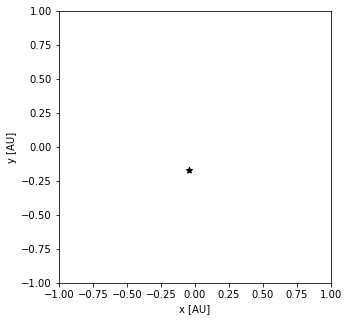

In [14]:
nframe = 100 # at home, I found 100 frames takes about 30 seconds to render
framestep = 5*sim.dt

for i in range(nframe):
    sim.integrate(sim.t + framestep)
    fig, ax = rebound.OrbitPlot(sim,color=True,unitlabel="[AU]",xlim=[-1,1],ylim=[-1,1])
    display(fig)
    plt.close(fig)
    clear_output(wait=True)

Finally, let's completely reimagine the system by assigning them the same orbital parameters but higher masses. Play with increasing the masses until you start to see dynamical instabilities show up in the animation. Based on their luminosities, we expect e, d, and c to all be about the same mass, and b is expected to be a bit lower.

In [13]:
# reset sim
del sim
sim = rebound.Simulation()

# Central star HR 8799 A
sim.add(m=1.50)                

# planet masses
mass_e = 7.3e-3
mass_d = mass_e
mass_c = mass_e
mass_b = mass_e * 0.5

sim.add(m=mass_e, a=16.64, e=0.1397, omega=118.8*dtor, M=1.261, inc=inc_pl, Omega=Omega_pl)
sim.add(m=mass_d, a=26.29, e=0.1112, omega=24.3*dtor, M=2.032, inc=inc_pl, Omega=Omega_pl)
sim.add(m=mass_c, a=43.12, e=0.0561, omega=28.5*dtor, M=4.232, inc=inc_pl, Omega=Omega_pl)
sim.add(m=mass_b, a=70.50, e=0.0113, omega=213.6*dtor, M=2.642, inc=inc_pl, Omega=Omega_pl)

sim.move_to_com()

After setting the planet masses, run the simulation. You may want to adjust nframe to make it run longer, but if you haven't broken it in 1000000 steps then then reset the masses above and try again. Alternatively, if you set the masses so high that it break immediately, try reducing them. We want to find an approximate mass that drives the system unstable within ~one million years.

TypeError: cannot unpack non-iterable OrbitPlot object

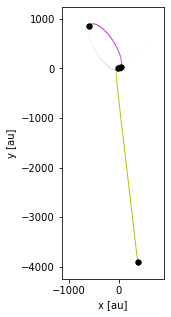

In [14]:
# run simulation
sim.integrate(1000000)

# plot endpoint
fig, ax = rebound.OrbitPlot(sim, color=True, periastron=False, unitlabel="[au]")

In [15]:
sim.status()

---------------------------------
REBOUND version:     	3.22.0
REBOUND built on:    	Nov 29 2022 00:39:21
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0000000000000000e+06
Current timestep:    	0.356593
---------------------------------
<rebound.particle.Particle object at 0x7f785731be40, m=1.5 x=1.7376152353331042 y=5.171620087335434 z=0.5650202222157105 vx=0.0016739777031964211 vy=0.0022330808596237634 vz=-0.0001782084482881186>
<rebound.particle.Particle object at 0x7f78574116c0, m=0.0073 x=-2.882747935412869 y=5.114436654109398 z=2.6617872673524414 vx=-0.4061932014805611 vy=-0.5008896563124788 vz=0.05401059732757451>
<rebound.particle.Particle object at 0x7f785731be40, m=0.0073 x=47.29755503159527 y=34.82392424088935 z=-12.46543296947617 vx=0.057488639562271196 vy=0.13018337819142572 vz=0.007939237176907792>
<rebound.particle.Particle object at 0x7f78574116c0, m=0.0073 x=-594.0389870306162 y=849.3376686233785 z=494.7384047434225 vx=-0.0045638280298894